In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
import numpy as np
from itertools import product
import pickle
import scipy.special
import scipy.stats
from math import exp
import multiprocessing
import functools

from montecarlo import DataLogger

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

from montecarlo import *

In [15]:
from time import time
t0 = time()
parameters = dict(N_sites = 64, t = 1, alpha = 1.5, mu = 0, beta = 1/2, J = 10, U = 10, normalise = True)
MCMC_params = dict(
        N_steps = int(1 * 1000),
        N_burn_in = int(0), 
        logger = DataLogger(),
        proposal = p_multi_site_poisson_reflect,
        proposal_args = dict(lam = 1),
        accept_function = perturbation_accept,
        warnings = True,
        info = True,
    )

bins, E, dE, IPR, dIPR = FK_mcmc_2(**MCMC_params, parameters = parameters)

/workspace/tch14/FKMC/notebooks/Second Wind/montecarlo.py:121: RuntimeWarning: invalid value encountered in true_divide
  p_classical_accept = logger.classical_accept_rates / sum(logger.classical_accept_rates) / p_propose
/workspace/tch14/FKMC/notebooks/Second Wind/montecarlo.py:122: RuntimeWarning: invalid value encountered in true_divide
  p_accept = logger.accept_rates / sum(logger.accept_rates) / p_propose


AttributeError: 'DataLogger' object has no attribute '__name__'

In [4]:
steps = np.arange(log.N_steps)
sites = np.arange(log.N_sites)

f, axes = plt.subplots(10,2, figsize = (25,15), sharey = 'row', gridspec_kw = dict(height_ratios=[2,2,2,2,1,1,1,1,1,1], width_ratios=[7, 1],wspace=0, hspace=0))

axs, axs1 = axes.T
observables = [_, _, _, _, log.Ff, log.Fc, log.Ff + log.Fc, log.Nf, log.Nc, log.Mf_moments[2], log.cMf_moments[2]]
observable_ylabels = ['f Occupation', 'Staggered Spins', 'Correlation', 'Eigenspectrum',
                      'Ff', 'Fc', 'F', 'Nf', 'Nc', 'M**2', '(M-M_bar)**2']

axs[0].pcolor(steps, sites, log.state.T, cmap = 'gray', vmin = 0, vmax = 1)
axs[1].pcolor(steps, sites, (log.state * log.A).T, cmap = 'gray', vmin = -1, vmax = 1)
#axs[2].pcolor(steps, sites[:correlation.shape[-1]], 1-correlation.T, cmap = 'gray', vmin = 0, vmax = 1)

x = np.reshape(steps[:, np.newaxis] * np.ones_like(log.eigenvals), [-1,])
y = np.reshape(log.eigenvals, [-1])
axs[3].scatter(x, y, alpha = 0.1,)

for ax,observable in list(zip(axs,observables))[4:]: ax.plot(steps, observable)

#axs1[0].plot(r.states.mean(axis=0), sites)
#axs1[1].plot(r.ts.mean(axis=0), sites)
#axs1[2].plot(correlation.mean(axis=0), sites[:correlation.shape[-1]])


hist_kwargs = dict(orientation='horizontal', bins = 20, density = True)
#axs1[3].plot(r.q_energy_histogram / np.sum(r.q_energy_histogram), r.q_energy_histogram_bins[:-1])

for ax,observable in list(zip(axs1,observables))[4:8]: ax.hist(observable, **hist_kwargs)

for ylabel, ax in zip(observable_ylabels, axs): ax.set(ylabel=ylabel)
axs[5].set(xlabel = 'MC Step (One trial per site per step)');

NameError: name 'log' is not defined

In [5]:
##compare to montecarlo
from direct_partition_functions import direct, states_to_numbers, number_to_state, enumerate_states
from montecarlo import *

N = 4
beta = 1/10
U = 1
J = 5
mu = 4
t = 1
alpha = 1.5
state = np.zeros(N, dtype = np.float64)
mcmc_steps = np.array([1e2,1e3,1e4], dtype = np.int)
N_steps = max(mcmc_steps)
N_burn_in = 0

ix, state_labels, states, Ffs, Fcs, Nfs, Ncs, Mf_moments = enumerate_states(N, mu, beta, U, J, t, alpha, normalise = True)
Boltz_factors = np.exp(- beta * (Ffs + Fcs))
Ps = Boltz_factors / np.sum(Boltz_factors)

#calculate the thermodynamic means
Fc, Ff, Nf, Nc = np.sum(np.array([Fcs, Ffs, Nfs, Ncs]) * Ps[None, :], axis = 1) 
Ff = np.sum(Ffs * Ps)
Mf_moment = np.sum(Mf_moments*Ps[None, :], axis = 1)

#log = FK_mcmc(
#log = FK_mcmc_random_pair(
#log = FK_mcmc_multi_site(
log =  mcmc(
    state=np.zeros(N),            
    N_steps = N_steps, N_burn_in = N_burn_in,
    mu = mu, beta = beta, J = J, alpha=alpha, U = U, t=t,
    logger = DataLogger(), normalise = True, N_multi_site = 4,
    )

mc_state_labels = states_to_numbers(log.state)
mc_label_count = np.bincount(mc_state_labels, minlength = 2**N)

#reorder the states into order of increasing energy
mc_label_count = mc_label_count[ix]/np.sum(mc_label_count)

mc_energies = log.Ff + log.Fc
print(f'p_acc = {log.p_acc}')
print(f'p_facc = {log.p_acc/log.p_facc}')

NameError: name 'mcmc' is not defined

NameError: name 'mc_state_labels' is not defined

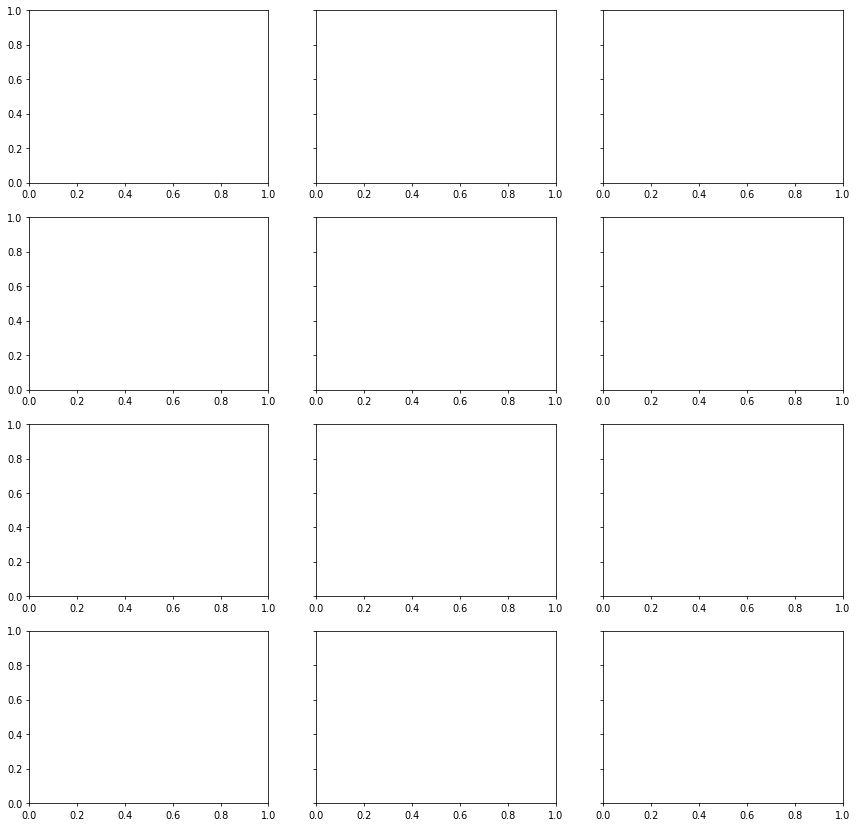

In [6]:
f, axes = plt.subplots(4,len(mcmc_steps), figsize = (5*len(mcmc_steps), 5*3), sharey = 'row')
for N_mc_steps, ax in zip(mcmc_steps, axes.T):

    #don't use the whole mcmc run, just the first N_mc_steps to see if it's converging
    chunksize = int(N_mc_steps/5)
    chunks = mc_state_labels[:N_mc_steps].reshape(-1,chunksize)
    binned_chunks = np.array([np.bincount(chunk, minlength = 2**N) for chunk in chunks])
    dmc_label_count = scipy.stats.sem(binned_chunks, axis = 0)
    
    mc_label_count = np.bincount(mc_state_labels[:N_mc_steps], minlength = 2**N)
    mc_label_count = mc_label_count[ix]
    dmc_label_count = dmc_label_count[ix]
    
    ax[0].set(title = f'{N_mc_steps} MC steps', xlabel = 'state label')
    
    ax[0].plot(np.arange(2**N), Ps, '--x')
    ax[0].errorbar(np.arange(2**N), mc_label_count/np.sum(mc_label_count),
                yerr= dmc_label_count/np.sum(mc_label_count), fmt = '.')
    
    for a, x, xlabel in zip(ax, 
                            [np.arange(2**N), Ffs + Fcs, Nfs+Ncs, Mf_moments[1],Mf_moments[2]],
                            ['State label','Total Free energy', 'N', 'M', 'M**2']):
        i = np.argsort(x)
        a.plot(x[i], Ps[i], '--x')
        a.errorbar(x[i], mc_label_count[i]/np.sum(mc_label_count),
                    yerr= dmc_label_count[i]/np.sum(mc_label_count), fmt = '.')
        a.set(xlabel = xlabel)

for ax in axes: ax[0].set(ylabel = 'State Probability');

To check the sanity of the monte carlo routine, the above plot compares the boltzman factor $exp(-\beta F) $ for each state of a small system (N=6) with the number of occurances seen during a monte carlo run. Each column shows these factors after an increasing number of montecarlo steps. Each row represents the states by a differnt measure, first they're simply ordered by increasing free energy, second they're plotted against free energy so that degernate states clump together. The 3rd and 4th show the overall occupation $Nf + Nc$ and the squared staggered magnetisation. 

[array([  6.19781219,   6.04456463,   5.78802148,   5.42001975,
         4.93784396,   4.34465553,   3.64900488,   2.86356685,
         2.0034439 ,   1.08443479,   0.12157759,  -0.8718833 ,
        -1.88510524,  -2.90992343,  -3.94092028,  -4.97540304,
        -6.0133717 ,  -7.05751904,  -8.11326261,  -9.18876724,
       -10.29487555, -11.44483196, -12.65367453, -13.93720202,
       -15.31051688, -16.78629398, -18.3730837 , -20.07404748,
       -21.88646986, -23.80218781]), array([ -1.12731361,  -1.32463727,  -1.55374899,  -1.81885339,
        -2.12443312,  -2.47518936,  -2.87596185,  -3.33162938,
        -3.84699359,  -4.42665114,  -5.07486023,  -5.79540909,
        -6.59149359,  -7.46561092,  -8.41947499,  -9.45395775,
       -10.5690592 , -11.76390738, -13.0367884 , -14.38520505,
       -15.80596148, -17.29526946, -18.84887076, -20.46216875,
       -22.13036177, -23.84857105, -25.61195684, -27.41581795,
       -29.25567175, -31.12731361]), array([0.19442267, 0.21904353, 0.24464628, 

ValueError: operands could not be broadcast together with shapes (10000,) (30,) 

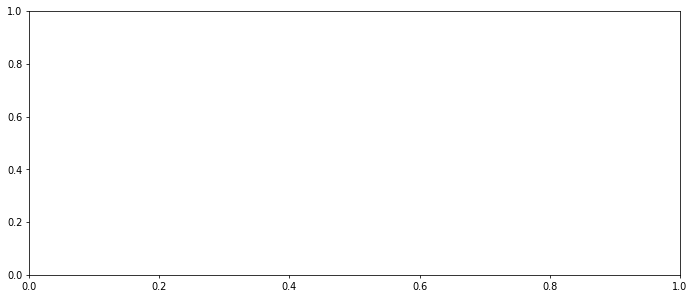

In [13]:
def running_mean(quantity):
    'return an array where the ith element is the mean of the first i values of the given array'
    return np.cumsum(quantity, axis = 0) / np.arange(1,quantity.shape[0]+1)

exacts = [Ff, Fc, Nf, Nc, Mf_moment[2], Mf_moment[4]]
print(exacts)
observables = [log.Ff, log.Fc,log.Nf,log.Nc,log.Mf_moments[2], log.Mf_moments[4]]
labels = ['Ff', 'Fc', 'Nf', 'Nc', 'M**2', 'M**4']

f, ax = plt.subplots(1,1, figsize = (12,5), sharex = 'all', gridspec_kw=dict(hspace = 0.5))

for x, label, exact in zip(observables, labels, exacts):
    ax.plot(np.arange(x.shape[0]), (running_mean(x)-exact)/exact * 100, label = label)

ax.plot((0,x.shape[0]),(0,0), 'k--')
ax.set(ylabel = '% deviation from expected value', xlim = (100,2000))
ax.legend()

The above plot shows the mean of each observable after x monte carlo steps, showing gradual convergence. Currently the Ff, Fc and Nc observables don't converge to the correct values!